In [26]:
doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
doc5 = "Health experts say that Sugar is not good for your lifestyle."

# compile documents
doc_complete = [doc1, doc2, doc3, doc4, doc5]

In [27]:
#Cleaning and Preprocessing
#Cleaning is an important step before any text mining task, in this step, we will remove the punctuations, 
#stopwords and normalize the corpus.
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string



In [28]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 

lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]

In [29]:
#Preparing Document-Term Matrix
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [30]:
#Running LDA Model
#Next step is to create an object for LDA model and train it on Document-Term matrix. The training also requires few 
#parameters as input which are explained in the above section. The gensim module 
#allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel


In [31]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [32]:
#Now let see the results..here 0 ,1, 2 ... are topic and sugar,bad and  so on are word of  that topic
print(ldamodel.print_topics(num_topics=3, num_words=3))
#Each line is a topic with individual topic terms and weights.Here weight represents how important that word is for the topic?
#Topic1 can be termed as Bad Health, and Topic3 can be termed as Family.

[(0, '0.045*"pressure" + 0.045*"feel" + 0.045*"perform"'), (1, '0.126*"sugar" + 0.072*"sister" + 0.072*"father"'), (2, '0.079*"driving" + 0.045*"cause" + 0.045*"increased"')]


In [38]:
from pprint import pprint
pprint(ldamodel.print_topics())

[(0,
  '0.045*"pressure" + 0.045*"feel" + 0.045*"drive" + 0.045*"perform" + '
  '0.045*"school" + 0.045*"sometimes" + 0.045*"well" + 0.045*"better" + '
  '0.045*"seems" + 0.045*"never"'),
 (1,
  '0.126*"sugar" + 0.072*"sister" + 0.072*"father" + 0.071*"consume" + '
  '0.071*"bad" + 0.071*"like" + 0.018*"expert" + 0.018*"lifestyle" + '
  '0.018*"health" + 0.018*"good"'),
 (2,
  '0.079*"driving" + 0.045*"may" + 0.045*"increased" + 0.045*"doctor" + '
  '0.045*"cause" + 0.045*"blood" + 0.045*"stress" + 0.045*"suggest" + '
  '0.045*"practice" + 0.045*"time"')]


In [49]:
import gensim.corpora as corpora
def format_topics_sentences(ldamodel=None, doc_term_matrix=doc_term_matrix, texts=doc_clean):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[doc_term_matrix]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [50]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, doc_term_matrix=doc_term_matrix, texts=doc_clean)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9137,"sugar, sister, father, consume, bad, like, exp...","[sugar, bad, consume, sister, like, sugar, fat..."
1,1,2.0,0.9297,"driving, may, increased, doctor, cause, blood,...","[father, spends, lot, time, driving, sister, a..."
2,2,2.0,0.9323,"driving, may, increased, doctor, cause, blood,...","[doctor, suggest, driving, may, cause, increas..."
3,3,0.0,0.9463,"pressure, feel, drive, perform, school, someti...","[sometimes, feel, pressure, perform, well, sch..."
4,4,0.0,0.8983,"pressure, feel, drive, perform, school, someti...","[health, expert, say, sugar, good, lifestyle]"


In [51]:
df_topic_distribution = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution["Num Documents"].sum()
df_topic_distribution

,Topic Num,Num Documents
0,0.0,2
1,2.0,2
2,1.0,1


In [52]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9463,"pressure, feel, drive, perform, school, sometimes, well, better, seems, never","[sometimes, feel, pressure, perform, well, school, father, never, seems, drive, sister, better]"
1,1.0,0.9137,"sugar, sister, father, consume, bad, like, expert, lifestyle, health, good","[sugar, bad, consume, sister, like, sugar, father]"
2,2.0,0.9323,"driving, may, increased, doctor, cause, blood, stress, suggest, practice, time","[doctor, suggest, driving, may, cause, increased, stress, blood, pressure]"


In [54]:
import matplotlib.pyplot as plt
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

<Figure size 2560x1120 with 1 Axes>

C:\Users\sunny\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\sunny\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\sunny\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sunny\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\sunny\Anaconda3\lib\site-packages\st

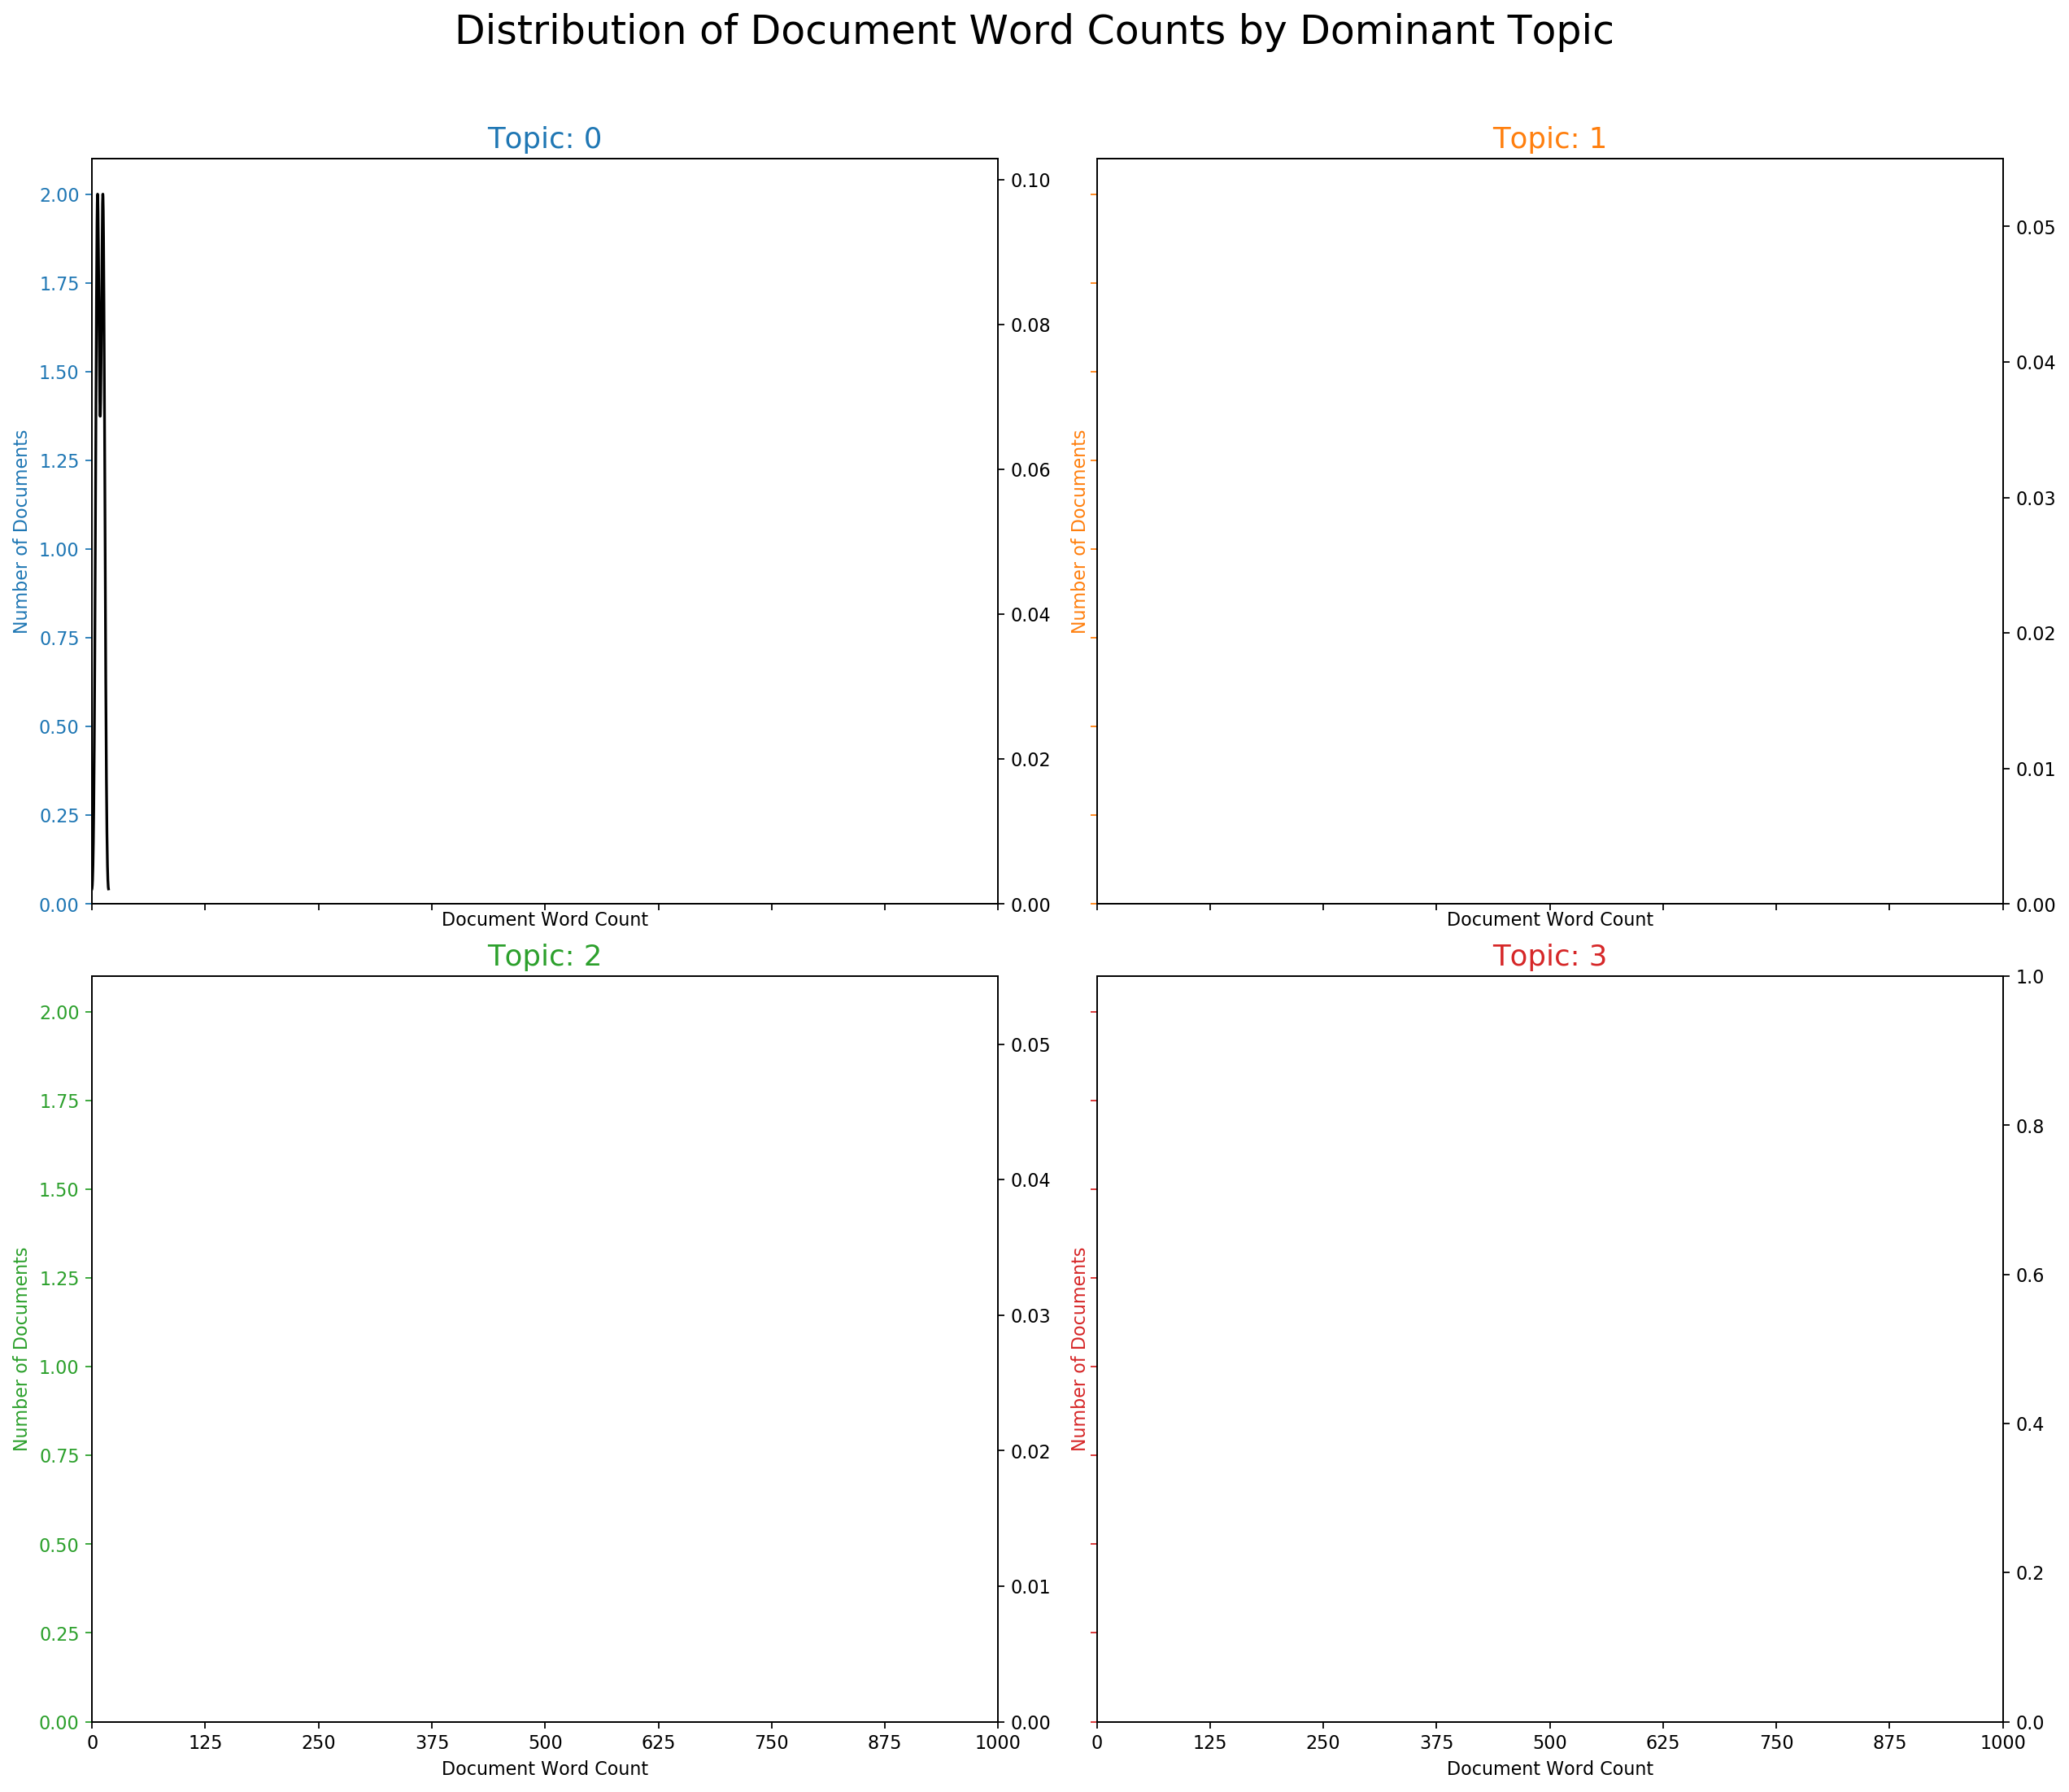

In [55]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

IndexError: list index out of range

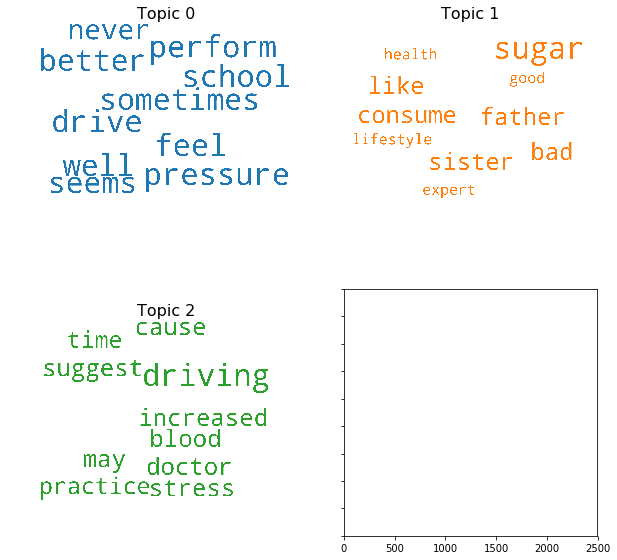

In [58]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [66]:
#Tips to improve results of topic modeling
#(1) Frequency Filter - 
    #Arrange every term according to its frequency.
    #Terms with higher frequencies are more likely to appear in the results as compared ones with low frequency.
    #The low frequency terms are essentially weak features of the corpus, hence it is a good practice to get rid 
        #of all those weak features.
    #An exploratory analysis of terms and their frequency can help to decide what frequency value should be considered 
        #as the threshold.

#(2) Part of Speech Tag Filter
    #POS tag filter is more about the context of the features than frequencies of features
    #So keep the POS which is sensible
#(3) Batch Wise LDA –
    #In order to retrieve most important topic terms, a corpus can be divided into batches of fixed sizes.
    #Running LDA multiple times on these batches will provide different results, however, the best topic
    #terms will be the intersection of all batches.
    
import os
os.getcwd()



'C:\\Users\\sunny'